# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator

C:\Users\sahit\Anaconda\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\sahit\Anaconda\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [2]:
def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

model_nlogo = NetLogoModel('predpreyNLOGO',
                     wd="./model/",
                     model_file="PredPrey.nlogo")
model_nlogo.run_length = 100
model_nlogo.replications = 10

model_nlogo.uncertainties = [RealParameter("prey_birth_rate", 0.015,0.035),
                       RealParameter("predation_rate", 0.0005, 0.003),
                       RealParameter("predator_efficiency", 0.001,0.004),
                       RealParameter("predator_loss_rate", 0.04, 0.08)
                       ]

model_nlogo.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [4]:
ema_logging.log_to_stderr(level=ema_logging.INFO)

model_xlsx = ExcelModel("preypreyXLSX", wd="./model/",
                   model_file='PredPrey.xlsx')
model_xlsx.uncertainties = [RealParameter("prey_birth_rate", 0.015,0.035),
                       RealParameter("predation_rate", 0.0005, 0.003),
                       RealParameter("predator_efficiency", 0.001,0.004),
                       RealParameter("predator_loss_rate", 0.04, 0.08)
                       ]

# specification of the outcomes
model_xlsx.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

# name of the sheet
model_xlsx.default_sheet = "Sheet1"

In [5]:
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate a model
wd = r'./model/'

model_pySD = PysdModel('PySD', mdl_file='./model/PredPrey.mdl')

model_pySD.uncertainties = [RealParameter("prey_birth_rate", 0.015,0.035),
                            RealParameter("predation_rate", 0.0005, 0.003),
                            RealParameter("predator_efficiency", 0.001,0.004),
                            RealParameter("predator_loss_rate", 0.04, 0.08)]

model_pySD.outcomes = [TimeSeriesOutcome('TIME'),
                       TimeSeriesOutcome('predators'),
                       TimeSeriesOutcome('prey')]

In [6]:
model_Python = Model('PredPreyPy', function=PredPrey)

model_Python.uncertainties = [RealParameter("prey_birth_rate", 0.015,0.035),
                              RealParameter("predation_rate", 0.0005, 0.003),
                              RealParameter("predator_efficiency", 0.001,0.004),
                              RealParameter("predator_loss_rate", 0.04, 0.08)]

model_Python.outcomes = [TimeSeriesOutcome('TIME'),
                         TimeSeriesOutcome('predators'),
                         TimeSeriesOutcome('prey')]

In [7]:
from ema_workbench import (save_results,load_results)

ema_logging.log_to_stderr(ema_logging.INFO)
experiments, outcomes = perform_experiments([model_xlsx,model_pySD, model_Python],100)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 3 model(s) = 300 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 210 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 270 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] experiments finished


In [8]:
from ema_workbench.analysis import plotting, plotting_util

In [11]:
outcomes

{'TIME': array([[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        ...,
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02]]),
 'predators': array([[20.        , 20.14563792, 20.29030707, ..., 16.20104845,
         16.36541704, 16.53040219],
        [20.        , 20.18932371, 20.38013355, ..., 24.63422647,
         24.4700773 , 24.3065349 ],
        [20.        , 20.19456756, 20.38577734, ..., 19.55316946,
         19.79630381, 20.03703086],
        ...,
        [20.        , 20.18370372, 20.37147753, ..., 20.74397973,
   

In [9]:
for o in outcomes.keys():
    outcomes[o] = outcomes[o][:,0,:]

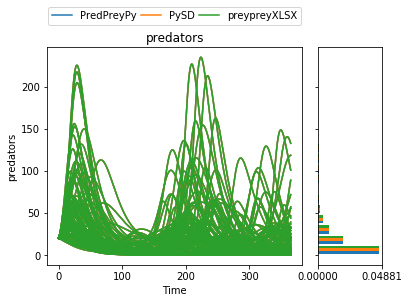

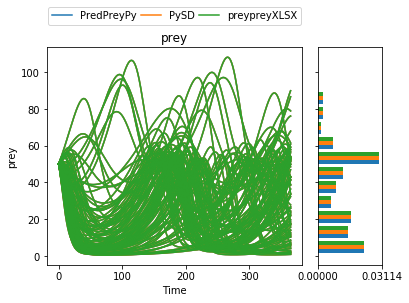

In [10]:
for outcome in outcomes.keys():
    if outcome!='TIME':
        plotting.lines(experiments, outcomes,outcomes_to_show=outcome, density=plotting_util.Density.HIST, group_by='model')
plt.show()